<a href="https://colab.research.google.com/github/MonitSharma/Quantum-Finance-and-Numerical-Methods/blob/main/Call_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pricing Call Options

#### Introduction

Suppose a call option with a strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a random distribution. The corresponding pay-off function is defined as :

$$ \max\{S_T - K, 0\} $$

In the following, a **quantum algorithm** based on amplitude estimation is used to estimate the expected pay-off, i.e the fair price before discounting , fot the option:

$$ \mathbb{E}\left[ \max\{S_T - K, 0\} \right] $$

as well as the corresponding $\Delta$ i.e the derivative of the option price with respect to the spot price , defined as:

$$ \Delta = \mathbb{P}\left[S_T \geq K\right] $$


The approximation of the objective function and a general introduction to the option pricing is given in the following papers:

1. [Quantum Risk Analysis, Woerner, Egger  2018](https://www.nature.com/articles/s41534-019-0130-6)

2. [Option Pricing using Quantum Computers](https://quantum-journal.org/papers/q-2020-07-06-291/)




In [1]:
%pip install qiskit[finance]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 5.2 MB/s 
     |████████████████████████████████| 12.8 MB 68.0 MB/s 
     |████████████████████████████████| 240 kB 74.2 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 106 kB 61.8 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 929 kB 62.3 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 159 kB 62.0 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 640 kB 59.7 MB/s 
     |████████████████████████████████| 4.0 MB 42.0 MB/s 
     |████████████████████████████████| 1.9 MB 43.9 MB/s 
     |████████████████████████████████| 1

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution


### Uncertainity Model

We construct a circuit to load a **log-normal random distribution** into a Quantum State . The distribution is truncated to a given interval $[\text{low}, \text{high}]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used. The used unitary operator corresponding to circuit implements:

$$ \big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n}, $$

where $p_i$ denotes the probability corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:


$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{\text{high} - \text{low}}{2^n - 1} * i + \text{low} \in [\text{low}, \text{high}]. $$


-----

#### Log-Normal Random Distribution:

A log-normal distribution is a continuous distribution of random variable $y$  whose natural logarithm is normally distributed. For example, if random variable $y = e^{y}$ has log-normal distribution then $ x = \log (y)$ has normal distribution. Log-normal distributions are most often used in finance to model stock prices, index values, asset returns, as well as exchange rates, derivatives, etc.

-----


#### Uncertainity Model

An uncertainty model is an implementation that provides a way to construct a quantum circuit to prepare a state which corresponds to a particular distribution. More precisely, the resulting state together with an affine map can be used to sample from the considered distribution. The qubits are measured and then mapped to the desired range using the affine map.

### Log-Normal Distribution Statistics

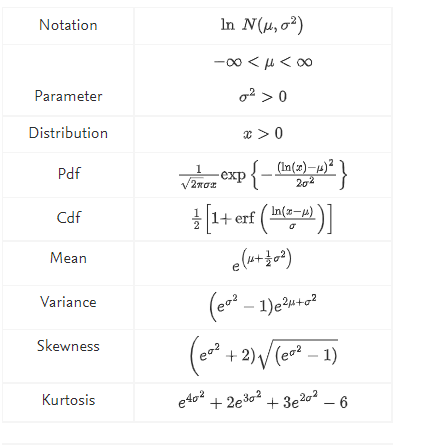

In [3]:
# number of qubits to represent the uncertainity
num_uncertainity_qubits = 5


# parameters for the random distribution

S = 2.0 # initial stock price
vol = 0.2 # volatality of 20%
r = 0.05 # annual interest rat of 5%
T = 50 / 365 # 50 days for maturity


# Resulting parameters from the above mentioned terms
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu+sigma**2/ 2)
variance = (np.exp(sigma**2)-1 )* np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and the highest value
# considered for the spot price; in between,
# an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev


# construct the A operator for QAE for the payoff function 
# by composing the uncertainity model and the objective

uncertainity_model = LogNormalDistribution(num_uncertainity_qubits, mu = mu, sigma = sigma**2, bounds=(low,high))
                                    


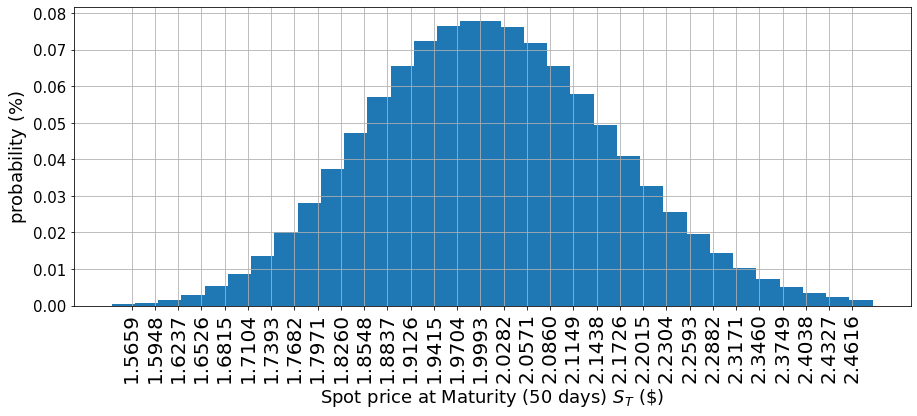

In [4]:
# plot the probability distribution function
plt.rcParams["figure.figsize"] = (15,5.5)
x = uncertainity_model.values
y = uncertainity_model.probabilities
plt.bar(x,y, width = 0.05)
plt.xticks(x, size = 20, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot price at Maturity (50 days) $S_T$ (\$)",size = 18)
plt.ylabel("probability ($\%$)", size = 18)
plt.show()

## Payoff Function

The payoff function equals zero as long as the stock price at maturity $S_T$ is less than tht strike price $K$ and then increase linearly. The implementation uses a comparator, that flips the ancilla qubit from $|0⟩$ to $|1⟩$ if $S_T \ge K$ and this ancilla is used to control the linear part of the payoff function.


-------

The linear part itseld is then approximated as follows. We exploit the fact that $ \sin^2(y + \pi/4) \approx y + 1/2 $ for small $|y|$. Thus for a given approximation rescaling factor $c_{\text{approx}} \in [0,1]$ and $x \in [0,1]$ we consider

$$ \sin^2( \pi/2 * c_\text{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_\text{approx} * ( x - 1/2 ) + 1/2 $$


------

We can easily construct an operator that acts as:

$$ \big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right), $$ using controlled Y rotations





Eventually we are interested in the probability of measuring $|1⟩$ in the last qubit, which correspond to $\sin^2(a \times x + b)$. Together with the approximation above, this allows to approximate the values of interest.

The smaller we chose $c_{\text{approx}}$ the better the approximation.

In [5]:
%pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 5.2 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=4caa7b48b275b0a7637081baad9c269f9f299b974b1b01bb87b030991531ccf7
  Stored in directory: /root/.cache/pip/wheels/72/99/be/81d9bcdf5dd5ee5acd8119a9dd5bc07204c9ce205fd341b021
Successfully built pylatexenc


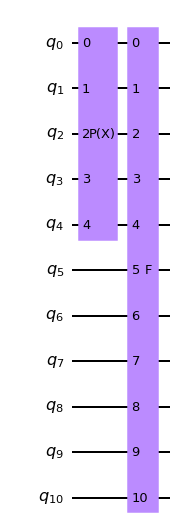

In [6]:
# set the strike price
strike_price = 1.9993

# set the approx scaling for the payoff

c_approx = 0.20

# swtup peice wise linear objective function
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainity_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainity_model, range(num_uncertainity_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw('mpl')






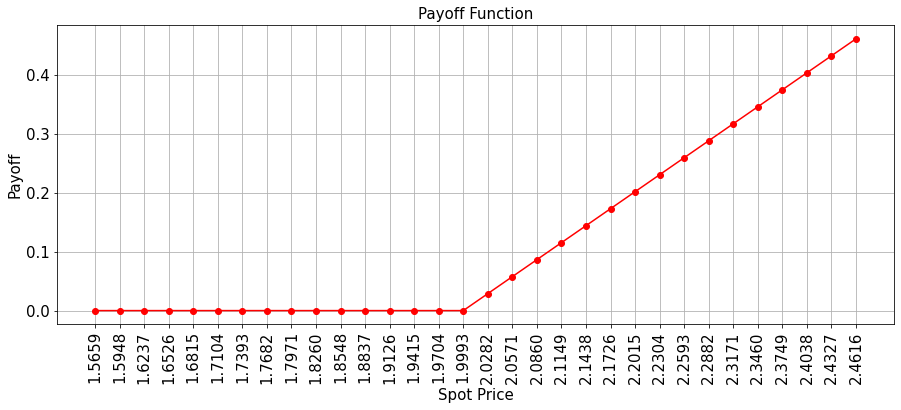

In [7]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainity_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [8]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainity_model.probabilities, y)
exact_delta = sum(uncertainity_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.0655
exact delta value:   	0.5620


## Evaluate Expected Payoff

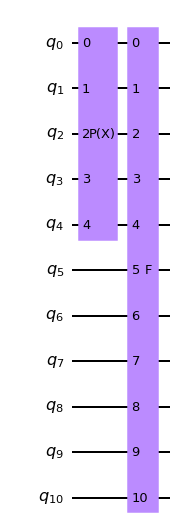

In [9]:
european_call.draw('mpl')

In [10]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [11]:
result = ae.estimate(problem)

In [12]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0655
Estimated value:    	0.2697
Confidence interval:	[0.2561, 0.2834]


Instead of constructing these circuits manually, Qiskit's finance module offers the `EuropeanCallPricing` circuit, which already implements this function.

In [13]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainity_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainity_model,
)

In [14]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0655
Estimated value:    	0.0681
Confidence interval:	[0.0651, 0.0710]


## Evaluate Delta

The Delta is a bit simler to evaluate than the expected payoff. Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases where $S_T > K$. However, since we are only interested in probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

In [18]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainity_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainity_model,
)

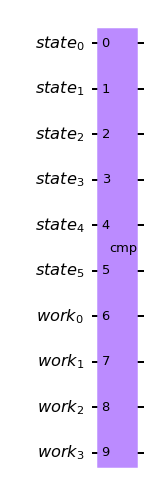

In [21]:
european_call_delta._objective.decompose().draw('mpl')

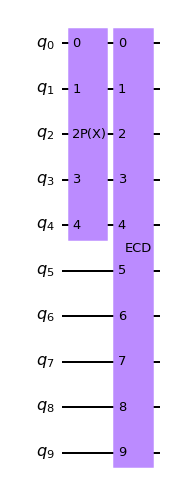

In [23]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainity_model, range(num_uncertainity_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw('mpl')

In [24]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)


In [25]:
result_delta = ae_delta.estimate(problem)

In [26]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.5620
Esimated value: 	0.5637
Confidence interval: 	[0.5589, 0.5684]
